# Initializing pySpark
We use the package [findspark](https://pypi.org/project/findspark/) in order to init the `SparkContext`. Since we're working with *[DataFrames](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame)* we need to init a `SparkSession` too. The pySpark version is **3.2.0**.<br>
The MovieLens dataset can be found at the following [link](https://files.grouplens.org/datasets/movielens/ml-1m.zip).

In [1]:
# Used to suppress the 'Deprecation Warnings' for Seaborn distplot
# No pySpark warning is suppressed by this option 
import warnings
warnings.filterwarnings("ignore")

import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("MovieLens Dataset").setMaster("local")
sc = SparkContext(conf=conf)
ss = SparkSession(sc)

21/12/03 11:51:13 WARN Utils: Your hostname, equilibria.local resolves to a loopback address: 127.0.0.1; using 157.27.138.149 instead (on interface en0)
21/12/03 11:51:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/03 11:51:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the Dataset
## Importing .dat files
The first step is to load the dataset, we can do this using the Pandas `read_table()` [function](https://pandas.pydata.org/docs/reference/api/pandas.read_table.html).<br>
Doing so we obtain 2 DataFrames:
* **Movies**: 3883 x 3
* **Ratings**: 1000209 x 4

In [2]:
import pandas as pd

movies_pd_dataset = pd.read_table("data/movies.dat", 
                                  delimiter="::", 
                                  names=["MovieID", "Title", "Genres"], 
                                  engine="python")

ratings_pd_dataset = pd.read_table("data/ratings.dat", 
                                   delimiter="::", 
                                   names=["UserID", "MovieID", "Rating", "Timestamp"], 
                                   engine="python")

In order to simplify data analisys, it's preferable to turn the "*Timestamp*" column into a more flexible date type.<br>
To do so we use the Pandas `to_datetime()` static [method](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html), followed by a *drop* of the "time part" of the data. The resulting date is formatted in the following way: `yyyy-mm-dd`. 

In [3]:
ratings_pd_dataset["Timestamp"] = pd.to_datetime(
    ratings_pd_dataset["Timestamp"],
    unit="s"
).dt.date

## Creating a Schema
In order to simplify the access to our DataFrames we provide a custom [schema](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.types.StructType.html) to the `createDataFrame()` [function](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html#pyspark.sql.SparkSession.createDataFrame).<br>
As a result of this operation is possible to specify which data [type](https://spark.apache.org/docs/latest/api/python/search.html?q=PySpark.sql.types#) we want to use for each column, reducing the space used by our DataFrames.

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, ShortType, DateType

movies_schema = StructType([
    StructField("MovieID", ShortType(), False),
    StructField("Title", StringType(), False),
    StructField("Genres", StringType(), False)
])

ratings_schema = StructType([
    StructField("UserID", ShortType(), False),
    StructField("MovieID", ShortType(), False),
    StructField("Rating", ShortType(), False),
    StructField("Date", DateType(), False)
])

movies_dataset = ss.createDataFrame(movies_pd_dataset, schema=movies_schema)
ratings_dataset = ss.createDataFrame(ratings_pd_dataset, schema=ratings_schema)

# Exploratory Analysis

## Query 1
Find the *number of ratings* and *distribution* for each movie

21/12/03 11:51:26 WARN TaskSetManager: Stage 0 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/03 11:51:27 WARN TaskSetManager: Stage 3 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-----+
|count|
+-----+
| 2077|
|  701|
|  478|
|  170|
|  296|
|  940|
|  458|
|   68|
|  102|
|  888|
| 1033|
|  160|
|   99|
|  153|
|  146|
|  682|
|  835|
|  157|
|  389|
|  160|
+-----+
only showing top 20 rows



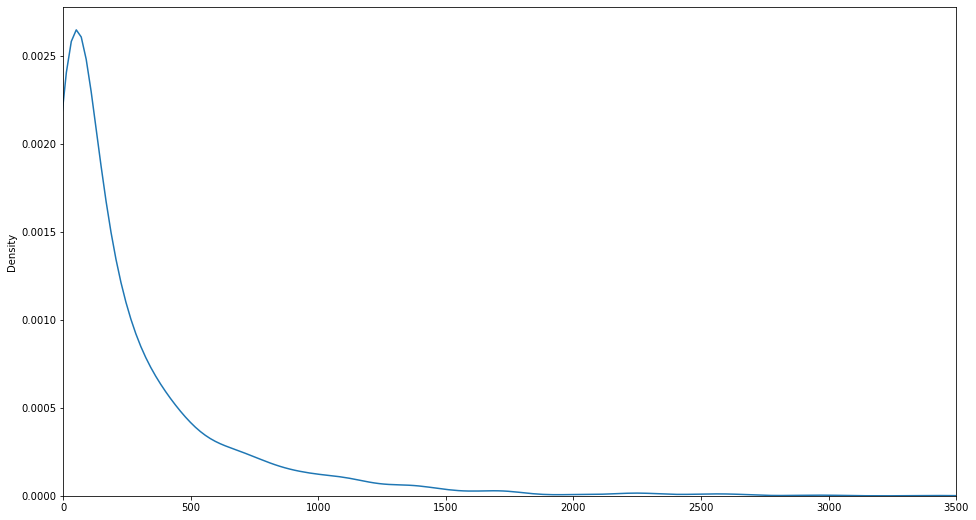

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of ratings
ratings_dataset.groupBy("MovieID").count().orderBy("MovieID")\
               .select("count").show()

# Distribution plot
plt.figure(figsize=(16,9))

sns.distplot(
    ratings_dataset.groupBy("MovieID").count()
                   .orderBy("MovieID")\
                   .select("count").toPandas(),
    hist=False,
    kde=True
)

plt.xlim([0, 3500])

plt.show()

## Query 2
Find the *number of ratings* and *distribution* for each user

21/12/03 11:51:28 WARN TaskSetManager: Stage 11 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-----+
|count|
+-----+
|   53|
|  129|
|   51|
|   21|
|  198|
|   71|
|   31|
|  139|
|  106|
|  401|
|  137|
|   23|
|  108|
|   25|
|  201|
|   35|
|  211|
|  305|
|  255|
|   24|
+-----+
only showing top 20 rows



21/12/03 11:51:29 WARN TaskSetManager: Stage 14 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


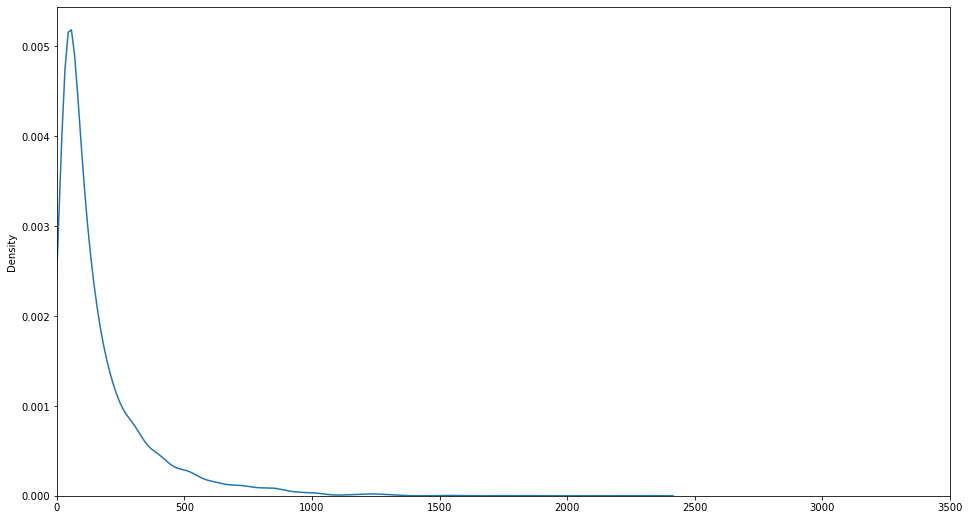

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of ratings
ratings_dataset.groupBy("UserID").count().orderBy("UserID")\
               .select("count").show()

# Distribution plot
plt.figure(figsize=(16,9))

sns.distplot(
    ratings_dataset.groupBy("UserID").count()
                   .orderBy("UserID")\
                   .select("count").toPandas(),
    hist=False,
    kde=True
)

plt.xlim([0, 3500])

plt.show()

## Query 3
Find the *average score* recieved by each movie

In [46]:
from pyspark.sql.functions import col, format_number, mean

ratings_dataset.groupBy("MovieID").agg(mean(col("Rating")))\
               .orderBy("MovieID")\
               .select(
                   "MovieID", 
                   format_number("avg(Rating)", 4).alias("Average")
               )\
               .show()

21/12/03 13:55:07 WARN TaskSetManager: Stage 124 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------+
|MovieID|Average|
+-------+-------+
|      1| 4.1468|
|      2| 3.2011|
|      3| 3.0167|
|      4| 2.7294|
|      5| 3.0068|
|      6| 3.8787|
|      7| 3.4105|
|      8| 3.0147|
|      9| 2.6569|
|     10| 3.5405|
|     11| 3.7938|
|     12| 2.3625|
|     13| 3.2626|
|     14| 3.5425|
|     15| 2.4589|
|     16| 3.7933|
|     17| 4.0275|
|     18| 3.3376|
|     19| 2.4807|
|     20| 2.5375|
+-------+-------+
only showing top 20 rows



## Query 4
Find the *average score* given by each user 

In [49]:
from pyspark.sql.functions import col, format_number, mean

ratings_dataset.groupBy("UserID").agg(mean(col("Rating")))\
               .orderBy("UserID")\
               .select(
                   "UserID", 
                   format_number("avg(Rating)", 4).alias("Average")
               )\
               .show()

21/12/03 13:55:38 WARN TaskSetManager: Stage 127 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+------+-------+
|UserID|Average|
+------+-------+
|     1| 4.1887|
|     2| 3.7132|
|     3| 3.9020|
|     4| 4.1905|
|     5| 3.1465|
|     6| 3.9014|
|     7| 4.3226|
|     8| 3.8849|
|     9| 3.7358|
|    10| 4.1147|
|    11| 3.2774|
|    12| 3.8261|
|    13| 3.3889|
|    14| 3.3200|
|    15| 3.3234|
|    16| 3.0286|
|    17| 4.0758|
|    18| 3.6492|
|    19| 3.5725|
|    20| 4.0833|
+------+-------+
only showing top 20 rows



## Query 5
Top **K** movies with at least **R** ratings

In [9]:
from pyspark.sql.functions import col

# Number of movies to show in the result
K = 10

# Minimum number of ratings each movie should have
R = 20

movies_dataset.join(ratings_dataset, "MovieID").groupBy("MovieID").count()\
              .orderBy("MovieID").withColumnRenamed("count", "Number of Ratings")\
              .filter(col("Number of Ratings") >= R).limit(K).show()

21/12/03 11:51:31 WARN TaskSetManager: Stage 29 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+
|MovieID|Number of Ratings|
+-------+-----------------+
|      1|             2077|
|      2|              701|
|      3|              478|
|      4|              170|
|      5|              296|
|      6|              940|
|      7|              458|
|      8|               68|
|      9|              102|
|     10|              888|
+-------+-----------------+



# Queries

## Query 1
Find if there is a correlation between the *standard deviation* of the **ratings** a movie has received, and the *number of ratings*.<br><br>
As shown in the plot, reducing the number of movies slightly alters the density of the data, but not in the way we expect. That's beacause instead of being distributed "*normally*" (following a **Normal Distribution**) as proven by the *Skewness* results at the bottom of the plot, the data follows a **Paretian Distribution** (as we can se from the side-to-side comparison below the distribution plot).

21/12/03 11:51:32 WARN TaskSetManager: Stage 35 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/03 11:51:32 WARN TaskSetManager: Stage 41 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/03 11:51:33 WARN TaskSetManager: Stage 47 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/03 11:51:34 WARN TaskSetManager: Stage 53 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 432x288 with 0 Axes>

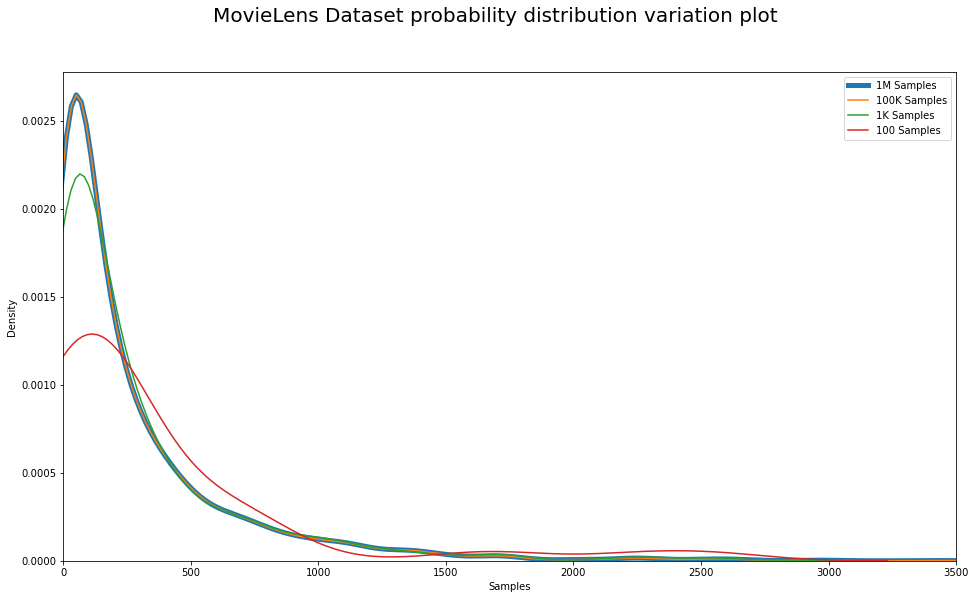

Skewness 1M samples: [0.]
Skewness 100K samples: [0.]
Skewness 1K samples: [8.78198508e-96]
Skewness 100 samples: [1.04995273e-12]


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import skew, skewtest
import seaborn as sns

one_M_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                              .groupBy("MovieID").count()\
                              .withColumnRenamed("count", "Number of Ratings")\
                              .select("Number of Ratings")\
                              .toPandas()

hundred_K_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                                  .groupBy("MovieID").count()\
                                  .withColumnRenamed("count", "Number of Ratings")\
                                  .select("Number of Ratings")\
                                  .limit(100000)\
                                  .toPandas()

one_K_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                              .groupBy("MovieID").count()\
                              .withColumnRenamed("count", "Number of Ratings")\
                              .select("Number of Ratings")\
                              .limit(1000)\
                              .toPandas()

hundred_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                                .groupBy("MovieID").count()\
                                .withColumnRenamed("count", "Number of Ratings")\
                                .select("Number of Ratings")\
                                .limit(100)\
                                .toPandas()

plt.clf()

fig = plt.figure(figsize=(16, 9))

fig.suptitle(
    "MovieLens Dataset probability distribution variation plot", 
    fontsize=20
)

sns.distplot(
    one_M_samples,
    hist=False,
    kde=True,
    kde_kws={"linewidth": 5},
    label="1M Samples"
)

sns.distplot(
    hundred_K_samples,
    hist=False,
    kde=True,
    label="100K Samples"
)

sns.distplot(
    one_K_samples,
    hist=False,
    kde=True,
    label="1K Samples"
)

sns.distplot(
    hundred_samples,
    hist=False,
    kde=True,
    label="100 Samples"
)

plt.legend()
plt.xlabel("Samples")
plt.xlim([0, 3500])

plt.show()

print(f"Skewness 1M samples: {skewtest(one_M_samples)[1]}")
print(f"Skewness 100K samples: {skewtest(hundred_K_samples)[1]}")
print(f"Skewness 1K samples: {skewtest(one_K_samples)[1]}")
print(f"Skewness 100 samples: {skewtest(hundred_samples)[1]}")

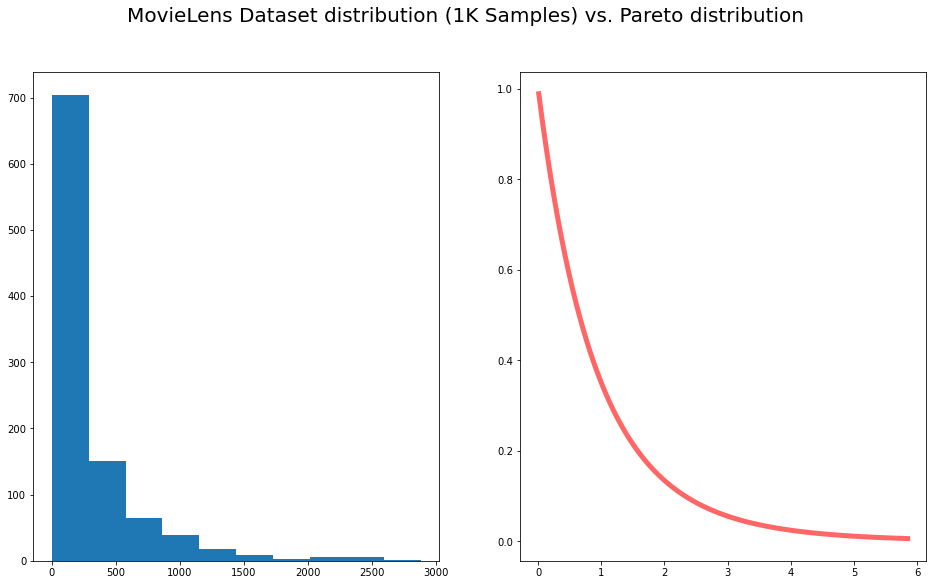

In [11]:
import numpy as np
from scipy.stats import genpareto

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

fig.suptitle(
    "MovieLens Dataset distribution (1K Samples) vs. Pareto distribution",
    fontsize=20
)

ax1.hist(one_K_samples)

c = 0.1

mean, var, skew, kurt = genpareto.stats(c, moments='mvsk')
x = np.linspace(genpareto.ppf(0.01, c), genpareto.ppf(0.99, c), 100)

ax2.plot(x, genpareto.pdf(x, c), 'r-', lw=5, alpha=0.6, label='genpareto pdf')

plt.show()

## Query 2
Find the *evolution over time* (with a granularity of **N** months) of the *number of ratings* and the *average rating*: do high rated movies maintain their ratings? Are low rated movies “abandoned” after a while?

In [102]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, mean, sum, trunc

N = 2

assert N in list(range(1, 13)), "N should represent the granularity, it must be in [1, 2, ..., 12]"

average_rating_per_movie = movies_dataset.join(ratings_dataset, "MovieID")\
                                         .groupBy("MovieID")\
                                         .agg(mean(col("Rating")))\
                                         .orderBy("MovieID")\
                                         .withColumnRenamed(
                                             "avg(Rating)", 
                                             "Average Rating"
                                         )

date_ordered_ratings_per_movie = ratings_dataset.groupBy("Date", "MovieID")\
                                                .agg(sum(col("Rating")))\
                                                .orderBy("MovieID", "Date")\
                                                .select(
                                                    "MovieID",
                                                    trunc(col("Date"), "Month"),
                                                    col("sum(Rating)")
                                                ).groupBy(
                                                    "MovieID", 
                                                    "trunc(Date, Month)"
                                                ).sum("sum(Rating)")\
                                                .orderBy(
                                                    "MovieID", 
                                                    "trunc(Date, Month)"
                                                ).withColumnRenamed(
                                                    "trunc(Date, Month)", 
                                                    "Year-Month"
                                                ).withColumnRenamed(
                                                    "sum(sum(Rating))",
                                                    "Number of Ratings"
                                                ).show()

# Rapporto tra media voti e numero voti (per heatmap plot)
# Le assi sono tempo e MovieID

21/12/03 16:21:16 WARN TaskSetManager: Stage 287 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-------+----------+-----------------+
|MovieID|Year-Month|Number of Ratings|
+-------+----------+-----------------+
|      1|2000-04-01|               68|
|      1|2000-05-01|              693|
|      1|2000-06-01|              526|
|      1|2000-07-01|              842|
|      1|2000-08-01|             1609|
|      1|2000-09-01|              462|
|      1|2000-10-01|              360|
|      1|2000-11-01|             2632|
|      1|2000-12-01|              965|
|      1|2001-01-01|              121|
|      1|2001-02-01|               59|
|      1|2001-03-01|               26|
|      1|2001-04-01|               23|
|      1|2001-05-01|                8|
|      1|2001-06-01|               27|
|      1|2001-07-01|               35|
|      1|2001-08-01|               27|
|      1|2001-09-01|               17|
|      1|2001-10-01|               15|
|      1|2001-11-01|               14|
+-------+----------+-----------------+
only showing top 20 rows

